In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from TrialSolution import TrialSolution

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Example 5

$\Delta\Psi(x, y)=\exp(-x)\left(x-2+y^3+6y\right)$

With boundary conditions $\Psi(0,y)=y^3$, $\Psi(1, y)=(1+y^3)e^{-1}$, $\Psi(x, 0)=xe^{-x}$, and $\Psi(x, 1)=(1+x)e^{-x}$.

The trial solution for this case is $\Psi(x, y)=A(x, y) + B(x, y)N(x, y)$ with $B(x)=x(1-x)y(1-y)$ and $$A(x, y)= (1-x)y^3+x(1+y^3)e^{-1}+(1-y)x(e^{-x}-e^{-1})+y[(1+x)e^{-x} - (1-x+2xe^{-1})].$$

The PDE will be considered on the domain $(x,y)\in[0,1]^2$

In [2]:
bcs = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: tf.reshape(X[:,1]**3, shape=(X.shape[0],1))},
        {'variable':0, 'value':1, 'type':'dirichlet',
        'function':lambda X: tf.reshape((tf.constant(1., dtype='float64', shape=(X.shape[0],1))+
        tf.reshape(X[:,1]**3, shape=(X.shape[0],1)))*tf.constant(np.exp(-1), dtype='float64', shape=(X.shape[0], 1)), shape=(X.shape[0], 1))},
        {'variable':1, 'value':0, 'type':'dirichlet',
        'function':lambda X: tf.reshape(X[:,0]*tf.exp(-X[:,0]), shape=(X.shape[0],1))},
        {'variable':1, 'value':1, 'type':'dirichlet',
        'function':lambda X: tf.reshape(
            (tf.reshape(X[:,0], shape=(X.shape[0],1))+tf.constant(1., dtype='float64', shape=(X.shape[0],1)))
            * tf.reshape(tf.exp(-X[:,0]), shape=(X.shape[0],1))
            , shape=(X.shape[0],1))}]

In [3]:
n_samples = 10
X_train = np.linspace(0, 1, n_samples)
Y_train = np.linspace(0, 1, n_samples)
X_train, Y_train = np.meshgrid(X_train, Y_train)
X_train = X_train.flatten()
Y_train = Y_train.flatten()
samples_train = np.array([X_train, Y_train]).T

In [4]:
n_samples_test = 100
X_test = np.linspace(0, 1, n_samples_test)
Y_test = np.linspace(0, 1, n_samples_test)
X_test, Y_test = np.meshgrid(X_test, Y_test)
X_test = X_test.flatten()
Y_test = Y_test.flatten()
samples_test = np.array([X_test, Y_test]).T

In [4]:
ts = TrialSolution(conditions=bcs, n_i=2, n_h=10, n_o=1, equation_type='PDE')

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(\Delta\Psi(x_i, N(x_i))-\exp(-x)\left(x-2+y^3+6y\right) \right)^2$$
And the Laplace operator term acting on the trial solution becomes:
$$\Delta\Psi(x_i, N(x_i))=\Delta A(x,y) + \Delta (x(1-x)y(1-y)N(x,y))$$
$$=e^{-x}(x+y-2)+6y(1-x+xe^{-1}) - 2N(x,y)(y(1-y)+x(1-x))+2\frac{\partial N}{\partial x}(x,y)(1-2x)y(1-y)+2\frac{\partial N}{\partial y}(x,y)(1-2y)x(1-x)+x(1-x)y(1-y)(\frac{\partial^2 N}{\partial x^2}(x,y)+\frac{\partial^2 N}{\partial y^2}(x,y))$$

In [5]:
def diff_loss(network, inputs):
  with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
      inputs = tf.convert_to_tensor(inputs)
      tape.watch(inputs)
      tape2.watch(inputs)
      response = network(inputs)  
    grads = tape.gradient(response, inputs)
  laplace = tape2.gradient(grads, inputs)
  two = tf.constant(2, dtype='float64')
  loss = tf.square(laplace[:,0] + laplace[:,1]
                   - tf.exp(-inputs[:,0])*(inputs[:,0] - two  + inputs[:,1]**3 + inputs[:,1]))
  return loss

### Training

In [6]:
ts.train(X=samples, diff_loss=diff_loss, epochs=100000, message_frequency=10000, optimizer_name='SGD', learning_rate=0.005)

Epoch: 10000 Loss: 0.13861733675003052
Epoch: 20000 Loss: 0.12473972141742706
Epoch: 30000 Loss: 0.11344094574451447
Epoch: 40000 Loss: 0.10640320926904678
Epoch: 50000 Loss: 0.10203249752521515
Epoch: 60000 Loss: 0.09896522760391235
Epoch: 70000 Loss: 0.09665161371231079
Epoch: 80000 Loss: 0.09481637924909592
Epoch: 90000 Loss: 0.09329627454280853
Epoch: 100000 Loss: 0.09201225638389587


### Plotting the results 

The numerical solution.

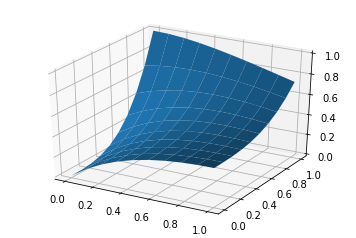

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
new_shape = int(np.sqrt(samples.shape[0]))
Ze5sol = tf.reshape(ts(samples), shape=(samples.shape[0],)).numpy()
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze5sol.reshape((new_shape, new_shape)), label='Numerical - Training')
plt.show()

The training error.

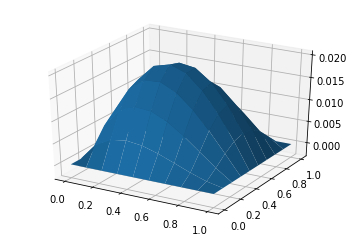

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Ze5anal = (samples[:,0] + samples[:,1]**3) * np.exp(-samples[:, 0])
Ze5diff = (Ze5sol - Ze5anal)
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze5diff.reshape((new_shape, new_shape)), label='Analytic')
# plt.legend()
plt.show()

The mean absolute error (*MAE*) on the trianing set.

In [9]:
np.abs(Ze5diff).mean()

0.0059130369930712875

The maximal absolute error on the trianing set.

In [12]:
np.max(np.abs(Ze5diff))

0.020386888754763466